In [ ]:
import pickle
from dataclasses import dataclass
import pandas as pd
import json
from typing import Optional
from drl_patches.sparse_autoencoders.get_vectorizer import load_tfidf_vectorizer
from drl_patches.sparse_autoencoders.getting_experiment_config import (
    load_training_indexes,
)
import torch
from drl_patches.logger import logger
from drl_patches.sparse_autoencoders.classical_data_mining import get_metrics
from drl_patches.sparse_autoencoders.utils import  set_seed
from drl_patches.sparse_autoencoders.vulnerability_detection_features import (
     get_vuln_safe_data
)
from drl_patches.sparse_autoencoders.getting_sorted_layer_features import (
    get_top_features,
    load_sorted_features,
)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
set_seed(42)
@dataclass
class Results:
    precision: float
    recall: float
    accuracy: float
    f1: float


@dataclass
class TransferabilityPerformance:
    on_defects: Optional[int] = None
    on_humaneval: Optional[int] = None
    on_gbug: Optional[int] = None

def calculate_f1_shift(
    results: Results,
    baseline_results: Results,
) -> dict:
    """
    Calculate the shift in perfoamcene in terms of F1 score % changed
    """
    f1_shift = (results.f1 - baseline_results.f1) / baseline_results.f1 * 100
    
    return f1_shift

# Save the results
def save_results(key, results, path="../artifacts/transferability_results.jsonl"):
    """
    Save the results to a jsonl file.
    """
    with open(path, "a") as f:
        f.write(json.dumps({key: results.__dict__}) + "\n")
    logger.info(f"Results saved to {path}")


2025-04-24 16:43:06 [info     ] Getting device.                device=cpu
2025-04-24 16:43:06 [info     ] Device                         device=cpu
2025-04-24 16:43:06 [info     ] Getting device.                device=cpu


In [2]:
@dataclass
class Dataset:
    dataset_path: str
    training_idx_path: str

GBUG_DATASET = Dataset(
    dataset_path="../artifacts/gbug-java.csv",
    training_idx_path="../artifacts/gbug-java_train_indexes.json",
)

DEFECT_DATASET = Dataset(
    dataset_path="../artifacts/defects4j.csv",
    training_idx_path="../artifacts/defects4j_train_indexes.json",
)

HUMAN_DATASET = Dataset(
    dataset_path="../artifacts/humaneval.csv",
    training_idx_path="../artifacts/humaneval_train_indexes.json",
)

In [3]:

def get_testing_dataset(dataset: Dataset):
    """
    Get the testing dataset path and the training indexes path.
    """
    df = pd.read_csv(dataset.dataset_path)
    with open( dataset.training_idx_path, "r") as f:
        training_indices = json.load(f)
    train_df = df.loc[training_indices]
    test_df = df.drop(train_df.index)

    return train_df, test_df
def evaluate_clf(clf, test_df, top_k)-> Results:
    """
    Evaluate the model on the test dataset.
    """

    X_test = test_df[top_k]
    X_test = torch.tensor(X_test.values, dtype=torch.float32)

    y_test = test_df["vuln"]

    y_pred = clf.predict(X_test)
    tp = sum((y_pred == 1) & (y_test == 1))
    fp = sum((y_pred == 1) & (y_test == 0))
    tn = sum((y_pred == 0) & (y_test == 0))
    fn = sum((y_pred == 0) & (y_test == 1))


    # Calculate the accuracy
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    # Calculate the precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Calculate the recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Calculate the F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return Results(precision=precision, recall=recall, accuracy=accuracy, f1=f1)


In [56]:
@dataclass
class SAE_ACTIVATIONS:
    layer: int
    top_k: int
    original_dataset_path: str
    base_gbug_path: str = "../gpt2_gbug-java/"
    base_defects_path: str = "../gpt2_defects4j/"
    base_humaneval_path: str = "../gpt2_humaneval/"

    @property
    def gbug_feature_safe_path(self):
        return self.base_gbug_path + "layer" + str(self.layer) + "/feature_importance_safe.jsonl"
    
    @property
    def gbug_feature_vuln_path(self):
        return self.base_gbug_path + "layer" + str(self.layer) + "/feature_importance_vuln.jsonl"
    
    @property
    def defects_feature_safe_path(self):
        return self.base_defects_path + "layer" + str(self.layer) + "/feature_importance_safe.jsonl"
    
    @property
    def defects_feature_vuln_path(self):
        return self.base_defects_path + "layer" + str(self.layer) + "/feature_importance_vuln.jsonl"
    
    @property
    def humaneval_feature_safe_path(self):
        return self.base_humaneval_path + "layer" + str(self.layer) + "/feature_importance_safe.jsonl"
    
    @property
    def humaneval_feature_vuln_path(self):
        return self.base_humaneval_path + "layer" + str(self.layer) + "/feature_importance_vuln.jsonl"
    
    @property
    def model_path(self):
        return self.base_gbug_path + "layer" + str(self.layer) + "/random_forest_k_" + str(self.top_k) + ".pt"

    @property
    def most_important_features_path(self):
        return self.original_dataset_path + "layer" + str(self.layer) + "/most_important_features.json"
    
    @property
    def model_path(self):
        return self.original_dataset_path + "layer" + str(self.layer) + "/random_forest_k_" + str(self.top_k) + ".pt"
    
SAE_ACTIVATIONS_GBUG_GPT2 = SAE_ACTIVATIONS(
    layer=11,
    top_k=20,
    original_dataset_path="../gpt2_gbug-java/",
)


SAE_ACTIVATIONS_DEFECTS4J = SAE_ACTIVATIONS(
    layer=4,
    top_k=5,
    original_dataset_path="../gpt2_defects4j/",
)

SAE_ACTIVATIONS_HUMANEVL = SAE_ACTIVATIONS(
    layer=2,
    top_k=10,
    original_dataset_path="../gpt2_humaneval/",
)




def load_sae_clf_settings(sae_activations: SAE_ACTIVATIONS):
    """
    Load the SAE classifier settings.
    """

    most_important_features = load_sorted_features(
        sae_activations.most_important_features_path
    )
    top_k = get_top_features(most_important_features, n=sae_activations.top_k)
    with open(sae_activations.model_path, "rb") as f:
        clf = pickle.load(f)

    return clf, top_k

def get_training_indexes(dataset: Dataset):
    with open(dataset.training_idx_path, "r") as f:
        training_indices = json.load(f)

    return training_indices

In [57]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_GBUG_GPT2)
# Original (GBUG)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GPT2.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GPT2.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_gbug_gpt2 = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gpt2)
# Defects4J
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GPT2.defects_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GPT2.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_gbug_gpt2_on_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gpt2_on_defects4j)
# Humaneval
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GPT2.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GPT2.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)

sae_rf_gbug_gpt2_on_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gpt2_on_humaneval)

transf_rf_gbug_gpt2_on_defects= calculate_f1_shift(
    sae_rf_gbug_gpt2_on_defects4j,
    sae_rf_gbug_gpt2,
)
transf_rf_gbug_gpt2_on_humaneval = calculate_f1_shift(
    sae_rf_gbug_gpt2_on_humaneval,
    sae_rf_gbug_gpt2,
)
transf_rf_gbug_gpt2 = TransferabilityPerformance(
    on_defects=transf_rf_gbug_gpt2_on_defects,
    on_humaneval=transf_rf_gbug_gpt2_on_humaneval,
)
save_results("sae_rf_gbug_gpt2", sae_rf_gbug_gpt2)
save_results("sae_rf_gbug_gpt2_on_defects4j", sae_rf_gbug_gpt2_on_defects4j)
save_results("sae_rf_gbug_gpt2_on_humaneval", sae_rf_gbug_gpt2_on_humaneval)
save_results("transf_rf_gbug_gpt2", transf_rf_gbug_gpt2)

100%|██████████| 24576/24576 [01:30<00:00, 271.17it/s]


Results(precision=0.8064516129032258, recall=0.8333333333333334, accuracy=0.8166666666666667, f1=0.819672131147541)


100%|██████████| 24576/24576 [01:36<00:00, 254.27it/s]


Results(precision=0.7564102564102564, recall=0.6210526315789474, accuracy=0.7105263157894737, f1=0.6820809248554913)


100%|██████████| 24576/24576 [01:38<00:00, 250.41it/s]


Results(precision=0.75, recall=0.09090909090909091, accuracy=0.5303030303030303, f1=0.16216216216216214)
2025-04-25 17:16:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:16:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:16:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:16:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [60]:
clf, top_k = load_sae_clf_settings( SAE_ACTIVATIONS_DEFECTS4J)
# Original (Defects4J)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J.defects_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j)
# GBUG
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_defects4j_on_gbug = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_on_gbug)
# Humaneval
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)
sae_rf_defects4j_on_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_on_humaneval)
transf_rf_defects4j_on_gbug = calculate_f1_shift(
    sae_rf_defects4j_on_gbug,
    sae_rf_defects4j,
)
transf_rf_defects4j_on_humaneval = calculate_f1_shift(
    sae_rf_defects4j_on_humaneval,
    sae_rf_defects4j,
)
transf_rf_defects4j_gpt2 = TransferabilityPerformance(
    on_gbug=transf_rf_defects4j_on_gbug,
    on_humaneval=transf_rf_defects4j_on_humaneval,
)
save_results("sae_rf_defects4j", sae_rf_defects4j)
save_results("sae_rf_defects4j_on_gbug", sae_rf_defects4j_on_gbug)
save_results("sae_rf_defects4j_on_humaneval", sae_rf_defects4j_on_humaneval)
save_results("transf_rf_defects4j_gpt2", transf_rf_defects4j_gpt2)

100%|██████████| 24576/24576 [01:40<00:00, 244.32it/s]


Results(precision=0.7578947368421053, recall=0.7578947368421053, accuracy=0.7578947368421053, f1=0.7578947368421053)


100%|██████████| 24576/24576 [01:36<00:00, 253.44it/s]


Results(precision=0.7272727272727273, recall=0.5333333333333333, accuracy=0.6666666666666666, f1=0.6153846153846153)


100%|██████████| 24576/24576 [01:39<00:00, 247.66it/s]


Results(precision=0.0, recall=0.0, accuracy=0.4696969696969697, f1=0)
2025-04-25 17:22:02 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:22:02 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:22:02 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:22:02 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [61]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_HUMANEVL)
# Original (Humaneval)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMANEVL.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_HUMANEVL.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)
sae_rf_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval)
# GBUG
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMANEVL.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_HUMANEVL.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_humaneval_on_gbug = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_on_gbug)
# Defects4J
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMANEVL.defects_feature_vuln_path,
    SAE_ACTIVATIONS_HUMANEVL.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_humaneval_on_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_on_defects4j)
transf_rf_humaneval_on_gbug = calculate_f1_shift(
    sae_rf_humaneval_on_gbug,
    sae_rf_humaneval,
)
transf_rf_humaneval_on_defects4j = calculate_f1_shift(
    sae_rf_humaneval_on_defects4j,
    sae_rf_humaneval,
)
transf_rf_humaneval_gpt2 = TransferabilityPerformance(
    on_defects=transf_rf_humaneval_on_defects4j,
    on_gbug=transf_rf_humaneval_on_gbug,
)
save_results("sae_rf_humaneval", sae_rf_humaneval)
save_results("sae_rf_humaneval_on_gbug", sae_rf_humaneval_on_gbug)
save_results("sae_rf_humaneval_on_defects4j", sae_rf_humaneval_on_defects4j)
save_results("transf_rf_humaneval_gpt2", transf_rf_humaneval_gpt2)



100%|██████████| 24576/24576 [01:35<00:00, 257.55it/s]


Results(precision=0.6129032258064516, recall=0.5757575757575758, accuracy=0.6060606060606061, f1=0.59375)


100%|██████████| 24576/24576 [01:32<00:00, 266.31it/s]


Results(precision=0.5277777777777778, recall=0.6333333333333333, accuracy=0.5333333333333333, f1=0.5757575757575758)


100%|██████████| 24576/24576 [01:36<00:00, 255.24it/s]


Results(precision=0.5, recall=0.47368421052631576, accuracy=0.5, f1=0.4864864864864865)
2025-04-25 17:27:04 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:27:04 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:27:04 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:27:04 [info     ] Results saved to ../artifacts/transferability_results.jsonl


## Gemma


In [67]:
SAE_ACTIVATIONS_GBUG_GEMMA2 = SAE_ACTIVATIONS(
    layer=13,
    top_k=100,
    original_dataset_path="../gemma2_gbug-java/",
    base_gbug_path="../gemma2_gbug-java/",
    base_defects_path="../gemma2_defects4j/",
    base_humaneval_path="../gemma2_humaneval/"
)

SAE_ACTIVATIONS_DEFECTS4J_GEMMA2 = SAE_ACTIVATIONS(
    layer=7,
    top_k=1,
    original_dataset_path="../gemma2_defects4j/",
    base_gbug_path="../gemma2_gbug-java/",
    base_defects_path="../gemma2_defects4j/",
    base_humaneval_path="../gemma2_humaneval/"
)

SAE_ACTIVATIONS_HUMAN_GEMMA2 = SAE_ACTIVATIONS(
    layer=8,
    top_k=4,
    original_dataset_path="../gemma2_humaneval/",
    base_gbug_path="../gemma2_gbug-java/",
    base_defects_path="../gemma2_defects4j/",
    base_humaneval_path="../gemma2_humaneval/"
)





In [68]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_GBUG_GEMMA2)
# Original (GBUG)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GEMMA2.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GEMMA2.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_gbug_gemma2 = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gemma2)
# Defects4J
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GEMMA2.defects_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GEMMA2.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_gbug_gemma2_on_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gemma2_on_defects4j)
# Humaneval
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GEMMA2.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GEMMA2.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)

sae_rf_gbug_gemma2_on_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gemma2_on_humaneval)

transf_rf_gbug_gemma2_on_defects= calculate_f1_shift(
    sae_rf_gbug_gemma2_on_defects4j,
    sae_rf_gbug_gemma2,
)
transf_rf_gbug_gemma2_on_humaneval = calculate_f1_shift(
    sae_rf_gbug_gemma2_on_humaneval,
    sae_rf_gbug_gemma2,
)
transf_rf_gbug_gemma2 = TransferabilityPerformance(
    on_defects=transf_rf_gbug_gemma2_on_defects,
    on_humaneval=transf_rf_gbug_gemma2_on_humaneval,
)
save_results("sae_rf_gbug_gemma2", sae_rf_gbug_gemma2)
save_results("sae_rf_gbug_gemma2_on_defects4j", sae_rf_gbug_gemma2_on_defects4j)
save_results("sae_rf_gbug_gemma2_on_humaneval", sae_rf_gbug_gemma2_on_humaneval)
save_results("transf_rf_gbug_gemma2", transf_rf_gbug_gemma2)

100%|██████████| 16384/16384 [00:35<00:00, 458.55it/s]


Results(precision=0.8484848484848485, recall=0.9333333333333333, accuracy=0.8833333333333333, f1=0.888888888888889)


100%|██████████| 16384/16384 [00:39<00:00, 416.88it/s]


Results(precision=0.525, recall=0.4421052631578947, accuracy=0.5210526315789473, f1=0.48000000000000004)


100%|██████████| 16384/16384 [00:38<00:00, 421.93it/s]


Results(precision=0.47619047619047616, recall=0.30303030303030304, accuracy=0.48484848484848486, f1=0.37037037037037035)
2025-04-25 17:54:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:54:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:54:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:54:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [69]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_DEFECTS4J_GEMMA2)
# Original (GBUG)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.defects_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_defects4j_gemma2 = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_gemma2)
# GBUG
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_defects4j_gemma2_on_gbug = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_gemma2_on_gbug)
# Humaneval
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)
sae_rf_defects4j_gemma2_on_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_gemma2_on_humaneval)
transf_rf_defects4j_gemma2_on_gbug = calculate_f1_shift(
    sae_rf_defects4j_gemma2_on_gbug,
    sae_rf_defects4j_gemma2,
)
transf_rf_defects4j_gemma2_on_humaneval = calculate_f1_shift(
    sae_rf_defects4j_gemma2_on_humaneval,
    sae_rf_defects4j_gemma2,
)
transf_rf_defects4j_gemma2 = TransferabilityPerformance(
    on_gbug=transf_rf_defects4j_gemma2_on_gbug,
    on_humaneval=transf_rf_defects4j_gemma2_on_humaneval,
)
save_results("sae_rf_defects4j_gemma2", sae_rf_defects4j_gemma2)
save_results("sae_rf_defects4j_gemma2_on_gbug", sae_rf_defects4j_gemma2_on_gbug)
save_results("sae_rf_defects4j_gemma2_on_humaneval", sae_rf_defects4j_gemma2_on_humaneval)
save_results("transf_rf_defects4j_gemma2", transf_rf_defects4j_gemma2)

100%|██████████| 16384/16384 [00:41<00:00, 390.16it/s]


Results(precision=0.5035460992907801, recall=0.7473684210526316, accuracy=0.5052631578947369, f1=0.6016949152542372)


100%|██████████| 16384/16384 [00:40<00:00, 407.08it/s]


Results(precision=0.4864864864864865, recall=0.6, accuracy=0.48333333333333334, f1=0.5373134328358209)


100%|██████████| 16384/16384 [00:39<00:00, 410.09it/s]


Results(precision=0.5, recall=1.0, accuracy=0.5, f1=0.6666666666666666)
2025-04-25 17:56:47 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:56:47 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:56:47 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:56:47 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [70]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_HUMAN_GEMMA2)
# Original (Humaneval)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMAN_GEMMA2.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_HUMAN_GEMMA2.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)
sae_rf_humaneval_gemma2 = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_gemma2)
# GBUG
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMAN_GEMMA2.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_HUMAN_GEMMA2.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_humaneval_gemma2_on_gbug = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_gemma2_on_gbug)
# Defects4J
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMAN_GEMMA2.defects_feature_vuln_path,
    SAE_ACTIVATIONS_HUMAN_GEMMA2.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_humaneval_gemma2_on_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_gemma2_on_defects4j)
transf_rf_humaneval_gemma2_on_gbug = calculate_f1_shift(
    sae_rf_humaneval_gemma2_on_gbug,
    sae_rf_humaneval_gemma2,
)
transf_rf_humaneval_gemma2_on_defects4j = calculate_f1_shift(
    sae_rf_humaneval_gemma2_on_defects4j,
    sae_rf_humaneval_gemma2,
)
transf_rf_humaneval_gemma2 = TransferabilityPerformance(
    on_defects=transf_rf_humaneval_gemma2_on_defects4j,
    on_gbug=transf_rf_humaneval_gemma2_on_gbug,
)
save_results("sae_rf_humaneval_gemma2", sae_rf_humaneval_gemma2)
save_results("sae_rf_humaneval_gemma2_on_gbug", sae_rf_humaneval_gemma2_on_gbug)
save_results("sae_rf_humaneval_gemma2_on_defects4j", sae_rf_humaneval_gemma2_on_defects4j)
save_results("transf_rf_humaneval_gemma2", transf_rf_humaneval_gemma2)

100%|██████████| 16384/16384 [00:38<00:00, 420.94it/s]


Results(precision=0.5777777777777777, recall=0.7878787878787878, accuracy=0.6060606060606061, f1=0.6666666666666666)


100%|██████████| 16384/16384 [00:38<00:00, 424.46it/s]


Results(precision=0.5238095238095238, recall=0.36666666666666664, accuracy=0.5166666666666667, f1=0.4313725490196078)


100%|██████████| 16384/16384 [00:42<00:00, 383.44it/s]


Results(precision=0.5263157894736842, recall=0.42105263157894735, accuracy=0.5210526315789473, f1=0.4678362573099415)
2025-04-25 17:58:57 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:58:57 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:58:57 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-25 17:58:57 [info     ] Results saved to ../artifacts/transferability_results.jsonl


# Baselines Transferability

In [107]:
@dataclass
class BaselineClassifier:
    path: str
    tfidf_vectorizer_path: str
    base_dataset: Dataset
    input_size: int

DEFECTS4J_KNN_BASELINE = BaselineClassifier(
    path="../ole/defects4j_knn_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=DEFECT_DATASET,
    input_size=5000,
)
GBUG_KNN_BASELINE = BaselineClassifier(
    path="../ole/gbug_knn_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=GBUG_DATASET,
    input_size=5000,
)
HUMANEVAL_KNN_BASELINE = BaselineClassifier(
    path="../ole/human_knn_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=HUMAN_DATASET,
    input_size=5000,
)
DEFECTS4J_RF_BASELINE = BaselineClassifier(
    path="../ole/defects4j_random_forest_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=DEFECT_DATASET,
    input_size=5000,
)
GBUG_RF_BASELINE = BaselineClassifier(
    path="../ole/gbug_random_forest_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=GBUG_DATASET,
    input_size=5000,
)
HUMANEVAL_RF_BASELINE = BaselineClassifier(
    path="../ole/human_random_forest_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=HUMAN_DATASET,
    input_size=5000,
)

def load_baseline_classifier(classifier: BaselineClassifier):
    with open(classifier.path, "rb") as f:
        clf = pickle.load(f)
    return clf

def test_baseline_classifier(clf, 
                             vectorizer, 
                             df, 
                             train_indexes,
                             before_func_col="func_before", 
                             after_func_col="func_after") -> Results:
    """
    Test the baseline classifier on the test dataset.
    """

    df["tokenized_before"] = df[before_func_col].progress_apply(
        lambda x: vectorizer.transform([x]).toarray()[0]
    )
    df["tokenized_after"] = df[after_func_col].progress_apply(
        lambda x: vectorizer.transform([x]).toarray()[0]
    )
    # Pad to 5000 tokens
    df["tokenized_before"] = df["tokenized_before"].apply(
        lambda x: x[:5000] + [0] * (5000 - len(x)) if len(x) < 5000 else x[:5000]
    )
    df["tokenized_after"] = df["tokenized_after"].apply(
        lambda x: x[:5000] + [0] * (5000 - len(x)) if len(x) < 5000 else x[:5000]
    )

    df_test = df.drop(train_indexes)

    df_classical_test = pd.DataFrame()
    for row in df_test.iterrows():
        row = row[1]
        df_classical_test = pd.concat(
            [
                df_classical_test,
                pd.DataFrame(
                    {"tokens": [row["tokenized_before"].tolist()], "vuln": 1}, index=[0]
                ),
            ]
        )
        df_classical_test = pd.concat(
            [
                df_classical_test,
                pd.DataFrame(
                    {"tokens": [row["tokenized_after"].tolist()], "vuln": 0}, index=[0]
                ),
            ]
        )

    X_test = df_classical_test["tokens"].values.tolist()
    X_test = [torch.tensor(x) for x in X_test]
    y_test = df_classical_test["vuln"]

    # Get the prediction
    y_pred = clf.predict(X_test)
    precision, recall, accuracy, f1 = get_metrics(y_pred, y_test)
    logger.info(
        "Classification report:",
        precision=precision,
        recall=recall,
        accuracy=accuracy,
        f1=f1,
    )
    return Results(
        precision=precision,
        recall=recall,
        accuracy=accuracy,
        f1=f1,
    )
    



In [108]:

results_gbug_knn = test_baseline_classifier(
    load_baseline_classifier(GBUG_KNN_BASELINE),
    load_tfidf_vectorizer(GBUG_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)

results_gbug_knn_defects = test_baseline_classifier(
    load_baseline_classifier(GBUG_KNN_BASELINE),
    load_tfidf_vectorizer(GBUG_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)

results_gbug_knn_human = test_baseline_classifier(
    load_baseline_classifier(GBUG_KNN_BASELINE),
    load_tfidf_vectorizer(GBUG_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)


transf_knn_gbug_on_defects= calculate_f1_shift(
    results_gbug_knn_defects,
    results_gbug_knn,
)
transf_knn_gbug_on_human= calculate_f1_shift(
    results_gbug_knn_human,
    results_gbug_knn,
)

transf_knn_gbug = TransferabilityPerformance(
    on_defects=transf_knn_gbug_on_defects,
    on_humaneval=transf_knn_gbug_on_human,
)

save_results("results_gbug_knn", results_gbug_knn)
save_results("results_gbug_knn_defects", results_gbug_knn_defects)
save_results("results_gbug_knn_human", results_gbug_knn_human)
save_results("transf_knn_gbug", transf_knn_gbug)


100%|██████████| 148/148 [00:00<00:00, 5113.99it/s]


2025-04-27 01:56:19 [info     ] Classification report:         accuracy=0.6666666666666666 f1=0.6774193548387096 precision=0.65625 recall=0.7


100%|██████████| 465/465 [00:00<00:00, 6653.79it/s]


2025-04-27 01:56:20 [info     ] Classification report:         accuracy=0.5 f1=0.4431137724550898 precision=0.5 recall=0.3978494623655914


100%|██████████| 162/162 [00:00<00:00, 7244.05it/s]


2025-04-27 01:56:20 [info     ] Classification report:         accuracy=0.48484848484848486 f1=0.43333333333333324 precision=0.48148148148148145 recall=0.3939393939393939
2025-04-27 01:56:20 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-27 01:56:20 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-27 01:56:20 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-27 01:56:20 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [110]:
### Random Forest from Gbug
results_gbug_rf = test_baseline_classifier(
    load_baseline_classifier(GBUG_RF_BASELINE),
    load_tfidf_vectorizer(GBUG_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)

results_gbug_rf_defects = test_baseline_classifier(
    load_baseline_classifier(GBUG_RF_BASELINE),
    load_tfidf_vectorizer(GBUG_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)

results_gbug_rf_human = test_baseline_classifier(
    load_baseline_classifier(GBUG_KNN_BASELINE),
    load_tfidf_vectorizer(GBUG_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)

transf_rf_gbug_on_defects= calculate_f1_shift(
    results_gbug_rf_defects,
    results_gbug_rf,
)
transf_rf_gbug_on_human= calculate_f1_shift(
    results_gbug_rf_human,
    results_gbug_rf,
)

transf_rf_gbug = TransferabilityPerformance(
    on_defects=transf_rf_gbug_on_defects,
    on_humaneval=transf_rf_gbug_on_human,
)

save_results("results_gbug_rf", results_gbug_rf)
save_results("results_gbug_rf_defects", results_gbug_rf_defects)
save_results("results_gbug_rf_human", results_gbug_rf_human)
save_results("transf_rf_gbug", transf_knn_gbug)

  0%|          | 0/148 [00:00<?, ?it/s]

100%|██████████| 148/148 [00:00<00:00, 4418.99it/s]

2025-04-27 01:56:41 [info     ] Classification report:         accuracy=0.75 f1=0.7058823529411764 precision=0.8571428571428571 recall=0.6



100%|██████████| 465/465 [00:00<00:00, 5764.44it/s]


2025-04-27 01:56:41 [info     ] Classification report:         accuracy=0.5161290322580645 f1=0.1176470588235294 precision=0.6666666666666666 recall=0.06451612903225806


100%|██████████| 162/162 [00:00<00:00, 2333.06it/s]


2025-04-27 01:56:41 [info     ] Classification report:         accuracy=0.48484848484848486 f1=0.43333333333333324 precision=0.48148148148148145 recall=0.3939393939393939
2025-04-27 01:56:41 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-27 01:56:41 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-27 01:56:41 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-27 01:56:41 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [16]:
results_defects_knn = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_KNN_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_defects_knn_gbug = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_KNN_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_defects_knn_human = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_KNN_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_knn_defects_on_gbug= calculate_f1_shift(
    results_defects_knn_gbug,
    results_defects_knn,
)
transf_knn_defects_on_human= calculate_f1_shift(
    results_defects_knn_human,
    results_defects_knn,
)

transf_knn_defects = TransferabilityPerformance(
    on_gbug=transf_knn_defects_on_gbug,
    on_humaneval=transf_knn_defects_on_human,
)
save_results("results_defects_knn", results_defects_knn)
save_results("results_defects_knn_gbug", results_defects_knn_gbug)
save_results("results_defects_knn_human", results_defects_knn_human)
save_results("transf_knn_defects", transf_knn_defects)

100%|██████████| 465/465 [00:00<00:00, 7126.76it/s]


2025-04-24 17:05:34 [info     ] Classification report:         accuracy=0.5376344086021505 f1=0.35820895522388063 precision=0.5853658536585366 recall=0.25806451612903225


100%|██████████| 148/148 [00:00<00:00, 4924.65it/s]


2025-04-24 17:05:35 [info     ] Classification report:         accuracy=0.5333333333333333 f1=0.43999999999999995 precision=0.55 recall=0.36666666666666664


100%|██████████| 162/162 [00:00<00:00, 7383.13it/s]


2025-04-24 17:05:35 [info     ] Classification report:         accuracy=0.5454545454545454 f1=0.4642857142857143 precision=0.5652173913043478 recall=0.3939393939393939
2025-04-24 17:05:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [17]:
results_defects_rf = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_RF_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_defects_rf_gbug = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_RF_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_defects_rf_human = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_RF_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_rf_defects_on_gbug= calculate_f1_shift(
    results_defects_rf_gbug,
    results_defects_rf,
)
transf_rf_defects_on_human= calculate_f1_shift(
    results_defects_rf_human,
    results_defects_rf,
)

transf_rf_defects = TransferabilityPerformance(
    on_gbug=transf_rf_defects_on_gbug,
    on_humaneval=transf_rf_defects_on_human,
)
save_results("results_defects_rf", results_defects_rf)
save_results("results_defects_rf_gbug", results_defects_rf_gbug)
save_results("results_defects_rf_human", results_defects_rf_human)
save_results("transf_rf_defects", transf_knn_defects)

100%|██████████| 465/465 [00:00<00:00, 5947.41it/s]


2025-04-24 17:05:35 [info     ] Classification report:         accuracy=0.521505376344086 f1=0.41830065359477125 precision=0.5333333333333333 recall=0.34408602150537637


100%|██████████| 148/148 [00:00<00:00, 5595.48it/s]


2025-04-24 17:05:35 [info     ] Classification report:         accuracy=0.5333333333333333 f1=0.36363636363636365 precision=0.5714285714285714 recall=0.26666666666666666


100%|██████████| 162/162 [00:00<00:00, 7364.33it/s]


2025-04-24 17:05:35 [info     ] Classification report:         accuracy=0.5 f1=0.6117647058823529 precision=0.5 recall=0.7878787878787878
2025-04-24 17:05:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:35 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [18]:
results_humaneval_knn = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_KNN_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_humaneval_knn_gbug = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_KNN_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_humaneval_knn_defects = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_KNN_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_knn_humaneval_on_gbug= calculate_f1_shift(
    results_humaneval_knn_gbug,
    results_humaneval_knn,
)
transf_knn_humaneval_on_defects= calculate_f1_shift(
    results_humaneval_knn_defects,
    results_humaneval_knn,
)

save_results("results_humaneval_knn", results_humaneval_knn)
save_results("results_humaneval_knn_gbug", results_humaneval_knn_gbug)
save_results("results_humaneval_knn_defects", results_humaneval_knn_defects)

transf_knn_humaneval = TransferabilityPerformance(
    on_gbug=transf_knn_humaneval_on_gbug,
    on_defects=transf_knn_humaneval_on_defects,
    on_humaneval=None,
)
print(transf_knn_humaneval)
save_results("transf_knn_humaneval", transf_knn_humaneval)

100%|██████████| 162/162 [00:00<00:00, 6109.97it/s]


2025-04-24 17:05:36 [info     ] Classification report:         accuracy=0.5757575757575758 f1=0.5625 precision=0.5806451612903226 recall=0.5454545454545454


100%|██████████| 148/148 [00:00<00:00, 5392.59it/s]


2025-04-24 17:05:36 [info     ] Classification report:         accuracy=0.48333333333333334 f1=0.5373134328358209 precision=0.4864864864864865 recall=0.6


100%|██████████| 465/465 [00:00<00:00, 6950.87it/s]


2025-04-24 17:05:36 [info     ] Classification report:         accuracy=0.5053763440860215 f1=0.5 precision=0.5054945054945055 recall=0.4946236559139785
2025-04-24 17:05:36 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:36 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:36 [info     ] Results saved to ../artifacts/transferability_results.jsonl
TransferabilityPerformance(on_defects=-11.11111111111111, on_humaneval=None, on_gbug=-4.477611940298508)
2025-04-24 17:05:36 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [19]:
results_humaneval_rf = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_RF_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_humaneval_rf_gbug = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_RF_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_humaneval_rf_defects = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_RF_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_rf_humaneval_on_gbug= calculate_f1_shift(
    results_humaneval_rf_gbug,
    results_humaneval_rf,
)
transf_rf_humaneval_on_defects= calculate_f1_shift(
    results_humaneval_rf_defects,
    results_humaneval_rf,
)
transf_rf_humaneval = TransferabilityPerformance(
    on_defects=transf_rf_humaneval_on_defects,
    on_gbug=transf_rf_humaneval_on_gbug,
)
save_results("results_humaneval_rf", results_humaneval_rf)
save_results("results_humaneval_rf_gbug", results_humaneval_rf_gbug)
save_results("results_humaneval_rf_defects", results_humaneval_rf_defects)
save_results("transf_rf_humaneval", transf_rf_humaneval)

100%|██████████| 162/162 [00:00<00:00, 4920.54it/s]


2025-04-24 17:05:36 [info     ] Classification report:         accuracy=0.5606060606060606 f1=0.4912280701754386 precision=0.5833333333333334 recall=0.42424242424242425


100%|██████████| 148/148 [00:00<00:00, 5182.82it/s]

2025-04-24 17:05:36 [info     ] Classification report:         accuracy=0.5 f1=0.16666666666666669 precision=0.5 recall=0.1



100%|██████████| 465/465 [00:00<00:00, 7065.90it/s]


2025-04-24 17:05:36 [info     ] Classification report:         accuracy=0.4946236559139785 f1=0.11320754716981131 precision=0.46153846153846156 recall=0.06451612903225806
2025-04-24 17:05:36 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:36 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:36 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:05:36 [info     ] Results saved to ../artifacts/transferability_results.jsonl


# Baselines with BERT-based model

In [20]:
@dataclass
class BERT_CLASSIFIER:
    path: str
    
MODERN_BERT_BASE_GBUG = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-base_artifacts_gbug-java.csv_best_model",
)

MODERN_BERT_BASE_DEFECTS = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-base_artifacts_defects4j.csv_best_model",
)
MODERN_BERT_BASE_HUMAN = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-base_artifacts_humaneval.csv_best_model",
)
MODERN_BERT_LARGE_GBUG = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-large_artifacts_gbug-java.csv_best_model",
)
MODERN_BERT_LARGE_DEFECTS = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-large_artifacts_defects4j.csv_best_model",
)
MODERN_BERT_LARGE_HUMAN = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-large_artifacts_humaneval.csv_best_model",
)
GRAPH_CODE_BERT_GBUG = BERT_CLASSIFIER(
    path="../microsoft_graphcodebert-base_artifacts_gbug-java.csv_best_model",
)
GRAPH_CODE_BERT_DEFECTS = BERT_CLASSIFIER(
    path="../microsoft_graphcodebert-base_artifacts_defects4j.csv_best_model",
)
GRAPH_CODE_BERT_HUMAN = BERT_CLASSIFIER(
    path="../microsoft_graphcodebert-base_artifacts_humaneval.csv_best_model",
)


In [21]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
def load_bert_model(model_path: str):
    """
    Load the BERT model from the given path.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_path,  trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

def test_bert_model(model, tokenizer, df, train_indexes):
    """
    Test the BERT model on the test dataset.
    """
    df_test = df.drop(train_indexes)

    X_test = df_test["func_before"].tolist() + df_test["func_after"].tolist()
    y_test = [1] * len(df_test) + [0] * len(df_test)

    y_pred_all = []

    for i in trange(len(X_test)):
        inputs = tokenizer(
            X_test[i],
            padding=True,
            truncation=True,
            return_tensors="pt",
        )

        outputs = model(**inputs)
        logits = outputs.logits
        y_pred = torch.argmax(logits, dim=1)
        y_pred_all.append(y_pred.item())
        
    
    precision, recall, accuracy, f1 = get_metrics(y_pred_all, y_test)
    logger.info(
        "Classification report:",
        precision=precision,
        recall=recall,
        accuracy=accuracy,
        f1=f1,
    )
    return Results(
        precision=precision,
        recall=recall,
        accuracy=accuracy,
        f1=f1,
    )


In [23]:
results_modern_bert_large_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_GBUG.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_large_gbug_on_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_GBUG.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)

results_modern_bert_large_gbug_on_human = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_GBUG.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_modern_bert_large_gbug_on_defects= calculate_f1_shift(
    results_modern_bert_large_gbug_on_defects,
    results_modern_bert_large_gbug,
)
transf_modern_bert_large_gbug_on_human= calculate_f1_shift(
    results_modern_bert_large_gbug_on_human,
    results_modern_bert_large_gbug,
)

# Save the results
save_results(
    "results_modern_bert_large_gbug",
    results_modern_bert_large_gbug,
)
save_results(
    "results_modern_bert_large_gbug_on_defects",
    results_modern_bert_large_gbug_on_defects,
)
save_results(
    "results_modern_bert_large_gbug_on_human",
    results_modern_bert_large_gbug_on_human,
)

100%|██████████| 60/60 [00:54<00:00,  1.09it/s]

2025-04-24 17:48:05 [info     ] Classification report:         accuracy=0.7 f1=0.71875 precision=0.6764705882352942 recall=0.7666666666666667



100%|██████████| 186/186 [02:09<00:00,  1.43it/s]

2025-04-24 17:50:15 [info     ] Classification report:         accuracy=0.553763440860215 f1=0.5464480874316939 precision=0.5555555555555556 recall=0.5376344086021505



100%|██████████| 66/66 [00:13<00:00,  4.88it/s]

2025-04-24 17:50:29 [info     ] Classification report:         accuracy=0.5151515151515151 f1=0.5999999999999999 precision=0.5106382978723404 recall=0.7272727272727273
2025-04-24 17:50:29 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:50:29 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:50:29 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [24]:
transf_modern_bert_large_gbug = TransferabilityPerformance(
    on_defects=transf_modern_bert_large_gbug_on_defects,
    on_humaneval=transf_modern_bert_large_gbug_on_human,
)
save_results("transf_modern_bert_large_gbug", transf_modern_bert_large_gbug)

2025-04-24 17:50:29 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [25]:
results_modern_bert_large_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_DEFECTS.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_modern_bert_large_defects_on_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_DEFECTS.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_large_defects_on_human = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_DEFECTS.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_modern_bert_large_defects_on_gbug= calculate_f1_shift(
    results_modern_bert_large_defects_on_gbug,
    results_modern_bert_large_defects,
)
transf_modern_bert_large_defects_on_human= calculate_f1_shift(
    results_modern_bert_large_defects_on_human,
    results_modern_bert_large_defects,
)
# Save the results
save_results(
    "results_modern_bert_large_defects",
    results_modern_bert_large_defects,
)
save_results(
    "results_modern_bert_large_defects_on_gbug",
    results_modern_bert_large_defects_on_gbug,
)
save_results(
    "results_modern_bert_large_defects_on_human",
    results_modern_bert_large_defects_on_human,
)

100%|██████████| 186/186 [02:18<00:00,  1.34it/s]

2025-04-24 17:52:48 [info     ] Classification report:         accuracy=0.5268817204301075 f1=0.5510204081632653 precision=0.5242718446601942 recall=0.5806451612903226



100%|██████████| 60/60 [00:48<00:00,  1.23it/s]

2025-04-24 17:53:37 [info     ] Classification report:         accuracy=0.5166666666666667 f1=0.5671641791044775 precision=0.5135135135135135 recall=0.6333333333333333



100%|██████████| 66/66 [00:13<00:00,  5.02it/s]

2025-04-24 17:53:50 [info     ] Classification report:         accuracy=0.5303030303030303 f1=0.5753424657534246 precision=0.525 recall=0.6363636363636364
2025-04-24 17:53:51 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:53:51 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:53:51 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [26]:
transf_modern_bert_large_defects = TransferabilityPerformance(
    on_defects=transf_modern_bert_large_defects_on_gbug,
    on_humaneval=transf_modern_bert_large_defects_on_human,
)
save_results("transf_modern_bert_large_defects", transf_modern_bert_large_defects)

2025-04-24 17:53:51 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [27]:
results_modern_bert_large_humaneval = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_HUMAN.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_modern_bert_large_humaneval_on_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_HUMAN.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_large_humaneval_on_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_HUMAN.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_modern_bert_large_humaneval_on_gbug= calculate_f1_shift(
    results_modern_bert_large_humaneval_on_gbug,
    results_modern_bert_large_humaneval,
)
transf_modern_bert_large_humaneval_on_defects= calculate_f1_shift(
    results_modern_bert_large_humaneval_on_defects,
    results_modern_bert_large_humaneval,
)
# Save the results
save_results(
    "results_modern_bert_large_humaneval",
    results_modern_bert_large_humaneval,
)
save_results(
    "results_modern_bert_large_humaneval_on_gbug",
    results_modern_bert_large_humaneval_on_gbug,
)

100%|██████████| 66/66 [00:18<00:00,  3.60it/s]

2025-04-24 17:54:09 [info     ] Classification report:         accuracy=0.5606060606060606 f1=0.5797101449275361 precision=0.5555555555555556 recall=0.6060606060606061



100%|██████████| 60/60 [00:49<00:00,  1.20it/s]

2025-04-24 17:54:59 [info     ] Classification report:         accuracy=0.5 f1=0.37499999999999994 precision=0.5 recall=0.3



100%|██████████| 186/186 [02:09<00:00,  1.44it/s]

2025-04-24 17:57:09 [info     ] Classification report:         accuracy=0.553763440860215 f1=0.4429530201342282 precision=0.5892857142857143 recall=0.3548387096774194
2025-04-24 17:57:09 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:57:09 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [28]:
transf_modern_bert_large_humaneval = TransferabilityPerformance(
    on_defects=transf_modern_bert_large_humaneval_on_defects,
    on_gbug=transf_modern_bert_large_humaneval_on_gbug,
)
save_results(
    "transf_modern_bert_large_humaneval",
    transf_modern_bert_large_humaneval,
)

2025-04-24 17:57:09 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [29]:
results_modern_bert_base_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_GBUG.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)

results_modern_bert_base_gbug_on_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_GBUG.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_modern_bert_base_gbug_on_human = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_GBUG.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_modern_bert_base_gbug_on_defects= calculate_f1_shift(
    results_modern_bert_base_gbug_on_defects,
    results_modern_bert_base_gbug,
)
transf_modern_bert_base_gbug_on_human= calculate_f1_shift(
    results_modern_bert_base_gbug_on_human,
    results_modern_bert_base_gbug,
)
# Save the results
save_results(
    "results_modern_bert_base_gbug",
    results_modern_bert_base_gbug,
)
save_results(
    "results_modern_bert_base_gbug_on_defects",
    results_modern_bert_base_gbug_on_defects,
)
save_results(
    "results_modern_bert_base_gbug_on_human",
    results_modern_bert_base_gbug_on_human,
)
transf_modern_bert_base_gbug = TransferabilityPerformance(
    on_defects=transf_modern_bert_base_gbug_on_defects,
    on_humaneval=transf_modern_bert_base_gbug_on_human,
)
save_results("transf_modern_bert_base_gbug", transf_modern_bert_base_gbug)

100%|██████████| 60/60 [00:26<00:00,  2.31it/s]

2025-04-24 17:57:35 [info     ] Classification report:         accuracy=0.6666666666666666 f1=0.7142857142857143 precision=0.625 recall=0.8333333333333334



100%|██████████| 186/186 [01:04<00:00,  2.88it/s]

2025-04-24 17:58:40 [info     ] Classification report:         accuracy=0.532258064516129 f1=0.42384105960264906 precision=0.5517241379310345 recall=0.34408602150537637



100%|██████████| 66/66 [00:06<00:00, 10.29it/s]

2025-04-24 17:58:46 [info     ] Classification report:         accuracy=0.5757575757575758 f1=0.5172413793103449 precision=0.6 recall=0.45454545454545453
2025-04-24 17:58:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:58:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:58:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 17:58:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [30]:
results_modern_bert_base_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_DEFECTS.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_modern_bert_base_defects_on_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_DEFECTS.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_base_defects_on_human = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_DEFECTS.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_modern_bert_base_defects_on_gbug= calculate_f1_shift(
    results_modern_bert_base_defects_on_gbug,
    results_modern_bert_base_defects,
)
transf_modern_bert_base_defects_on_human= calculate_f1_shift(
    results_modern_bert_base_defects_on_human,
    results_modern_bert_base_defects,
)
# Save the results
save_results(
    "results_modern_bert_base_defects",
    results_modern_bert_base_defects,
)
save_results(
    "results_modern_bert_base_defects_on_gbug",
    results_modern_bert_base_defects_on_gbug,
)
save_results(
    "results_modern_bert_base_defects_on_human",
    results_modern_bert_base_defects_on_human,
)

100%|██████████| 186/186 [01:03<00:00,  2.93it/s]

2025-04-24 17:59:50 [info     ] Classification report:         accuracy=0.553763440860215 f1=0.48447204968944096 precision=0.5735294117647058 recall=0.41935483870967744



100%|██████████| 60/60 [00:24<00:00,  2.47it/s]

2025-04-24 18:00:15 [info     ] Classification report:         accuracy=0.5333333333333333 f1=0.5172413793103449 precision=0.5357142857142857 recall=0.5



100%|██████████| 66/66 [00:07<00:00,  9.25it/s]

2025-04-24 18:00:22 [info     ] Classification report:         accuracy=0.5 f1=0.5714285714285715 precision=0.5 recall=0.6666666666666666
2025-04-24 18:00:22 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:00:22 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:00:22 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [31]:

transf_modern_bert_base_defects = TransferabilityPerformance(
    on_gbug=transf_modern_bert_base_defects_on_gbug,
    on_humaneval=transf_modern_bert_base_defects_on_human,
)
save_results("transf_modern_bert_base_defects", transf_modern_bert_base_defects)

2025-04-24 18:00:22 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [32]:
results_modern_bert_base_humaneval = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_HUMAN.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_modern_bert_base_humaneval_on_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_HUMAN.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_base_humaneval_on_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_HUMAN.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_modern_bert_base_humaneval_on_gbug= calculate_f1_shift(
    results_modern_bert_base_humaneval_on_gbug,
    results_modern_bert_base_humaneval,
)
transf_modern_bert_base_humaneval_on_defects= calculate_f1_shift(
    results_modern_bert_base_humaneval_on_defects,
    results_modern_bert_base_humaneval,
)

# Save the results
save_results(
    "results_modern_bert_base_humaneval",
    results_modern_bert_base_humaneval,
)
save_results(
    "results_modern_bert_base_humaneval_on_gbug",
    results_modern_bert_base_humaneval_on_gbug,
)
save_results(
    "results_modern_bert_base_humaneval_on_defects",
    results_modern_bert_base_humaneval_on_defects,
)
transf_modern_bert_base_humaneval = TransferabilityPerformance(
    on_defects=transf_modern_bert_base_humaneval_on_defects,
    on_gbug=transf_modern_bert_base_humaneval_on_gbug,
)
save_results(
    "transf_modern_bert_base_humaneval",
    transf_modern_bert_base_humaneval,
)

100%|██████████| 66/66 [00:06<00:00,  9.68it/s]

2025-04-24 18:00:29 [info     ] Classification report:         accuracy=0.6060606060606061 f1=0.6285714285714286 precision=0.5945945945945946 recall=0.6666666666666666



100%|██████████| 60/60 [00:23<00:00,  2.55it/s]

2025-04-24 18:00:53 [info     ] Classification report:         accuracy=0.5166666666666667 f1=0.4081632653061224 precision=0.5263157894736842 recall=0.3333333333333333



100%|██████████| 186/186 [01:02<00:00,  2.99it/s]

2025-04-24 18:01:55 [info     ] Classification report:         accuracy=0.5698924731182796 f1=0.47368421052631576 precision=0.6101694915254238 recall=0.3870967741935484
2025-04-24 18:01:55 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:01:55 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:01:55 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:01:55 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [33]:
results_graph_code_bert_gbug = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_GBUG.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_graph_code_bert_gbug_on_defects = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_GBUG.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_graph_code_bert_gbug_on_human = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_GBUG.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_graph_code_bert_gbug_on_defects= calculate_f1_shift(
    results_graph_code_bert_gbug_on_defects,
    results_graph_code_bert_gbug,
)
transf_graph_code_bert_gbug_on_human= calculate_f1_shift(
    results_graph_code_bert_gbug_on_human,
    results_graph_code_bert_gbug,
)
# Save the results
save_results(
    "results_graph_code_bert_gbug",
    results_graph_code_bert_gbug,
)
save_results(
    "results_graph_code_bert_gbug_on_defects",
    results_graph_code_bert_gbug_on_defects,
)
save_results(
    "results_graph_code_bert_gbug_on_human",
    results_graph_code_bert_gbug_on_human,
)
transf_graph_code_bert_gbug = TransferabilityPerformance(
    on_defects=transf_graph_code_bert_gbug_on_defects,
    on_humaneval=transf_graph_code_bert_gbug_on_human,
)
save_results("transf_graph_code_bert_gbug", transf_graph_code_bert_gbug)

100%|██████████| 60/60 [00:08<00:00,  7.16it/s]

2025-04-24 18:02:04 [info     ] Classification report:         accuracy=0.6333333333333333 f1=0.6451612903225806 precision=0.625 recall=0.6666666666666666



100%|██████████| 186/186 [00:24<00:00,  7.51it/s]

2025-04-24 18:02:29 [info     ] Classification report:         accuracy=0.5053763440860215 f1=0.5208333333333333 precision=0.5050505050505051 recall=0.5376344086021505



100%|██████████| 66/66 [00:05<00:00, 11.91it/s]

2025-04-24 18:02:34 [info     ] Classification report:         accuracy=0.5151515151515151 f1=0.6521739130434782 precision=0.5084745762711864 recall=0.9090909090909091


2025-04-24 18:02:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:02:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:02:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:02:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [34]:
results_graph_code_bert_defects = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_DEFECTS.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_graph_code_bert_defects_on_gbug = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_DEFECTS.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_graph_code_bert_defects_on_human = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_DEFECTS.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_graph_code_bert_defects_on_gbug= calculate_f1_shift(
    results_graph_code_bert_defects_on_gbug,
    results_graph_code_bert_defects,
)
transf_graph_code_bert_defects_on_human= calculate_f1_shift(
    results_graph_code_bert_defects_on_human,
    results_graph_code_bert_defects,
)
# Save the results
save_results(
    "results_graph_code_bert_defects",
    results_graph_code_bert_defects,
)
save_results(
    "results_graph_code_bert_defects_on_gbug",
    results_graph_code_bert_defects_on_gbug,
)
save_results(
    "results_graph_code_bert_defects_on_human",
    results_graph_code_bert_defects_on_human,
)

100%|██████████| 186/186 [00:24<00:00,  7.72it/s]

2025-04-24 18:02:59 [info     ] Classification report:         accuracy=0.543010752688172 f1=0.5142857142857143 precision=0.5487804878048781 recall=0.4838709677419355



100%|██████████| 60/60 [00:07<00:00,  7.91it/s]

2025-04-24 18:03:07 [info     ] Classification report:         accuracy=0.5333333333333333 f1=0.4814814814814815 precision=0.5416666666666666 recall=0.43333333333333335



100%|██████████| 66/66 [00:05<00:00, 12.44it/s]

2025-04-24 18:03:12 [info     ] Classification report:         accuracy=0.48484848484848486 f1=0.45161290322580644 precision=0.4827586206896552 recall=0.42424242424242425
2025-04-24 18:03:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:03:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:03:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [35]:

transf_graph_code_bert_defects = TransferabilityPerformance(
    on_gbug=transf_graph_code_bert_defects_on_gbug,
    on_humaneval=transf_graph_code_bert_defects_on_human,
)
save_results("transf_graph_code_bert_defects", transf_graph_code_bert_defects)

2025-04-24 18:03:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [36]:
results_graph_code_bert_humaneval = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_HUMAN.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_graph_code_bert_humaneval_on_gbug = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_HUMAN.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_graph_code_bert_humaneval_on_defects = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_HUMAN.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_graph_code_bert_humaneval_on_gbug= calculate_f1_shift(
    results_graph_code_bert_humaneval_on_gbug,
    results_graph_code_bert_humaneval,
)
transf_graph_code_bert_humaneval_on_defects= calculate_f1_shift(
    results_graph_code_bert_humaneval_on_defects,
    results_graph_code_bert_humaneval,
)
# Save the results
save_results(
    "results_graph_code_bert_humaneval",
    results_graph_code_bert_humaneval,
)
save_results(
    "results_graph_code_bert_humaneval_on_gbug",
    results_graph_code_bert_humaneval_on_gbug,
)
save_results(
    "results_graph_code_bert_humaneval_on_defects",
    results_graph_code_bert_humaneval_on_defects,
)

transf_graph_code_bert_humaneval = TransferabilityPerformance(
    on_defects=transf_graph_code_bert_humaneval_on_defects,
    on_gbug=transf_graph_code_bert_humaneval_on_gbug,
)
save_results(
    "transf_graph_code_bert_humaneval",
    transf_graph_code_bert_humaneval,
)

100%|██████████| 66/66 [00:06<00:00, 10.52it/s]

2025-04-24 18:03:19 [info     ] Classification report:         accuracy=0.5606060606060606 f1=0.5245901639344263 precision=0.5714285714285714 recall=0.48484848484848486



100%|██████████| 60/60 [00:07<00:00,  8.00it/s]

2025-04-24 18:03:26 [info     ] Classification report:         accuracy=0.5166666666666667 f1=0.29268292682926833 precision=0.5454545454545454 recall=0.2



100%|██████████| 186/186 [00:23<00:00,  8.06it/s]

2025-04-24 18:03:49 [info     ] Classification report:         accuracy=0.5161290322580645 f1=0.296875 precision=0.5428571428571428 recall=0.20430107526881722
2025-04-24 18:03:49 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:03:49 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:03:49 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-24 18:03:49 [info     ] Results saved to ../artifacts/transferability_results.jsonl


# Feature Importance

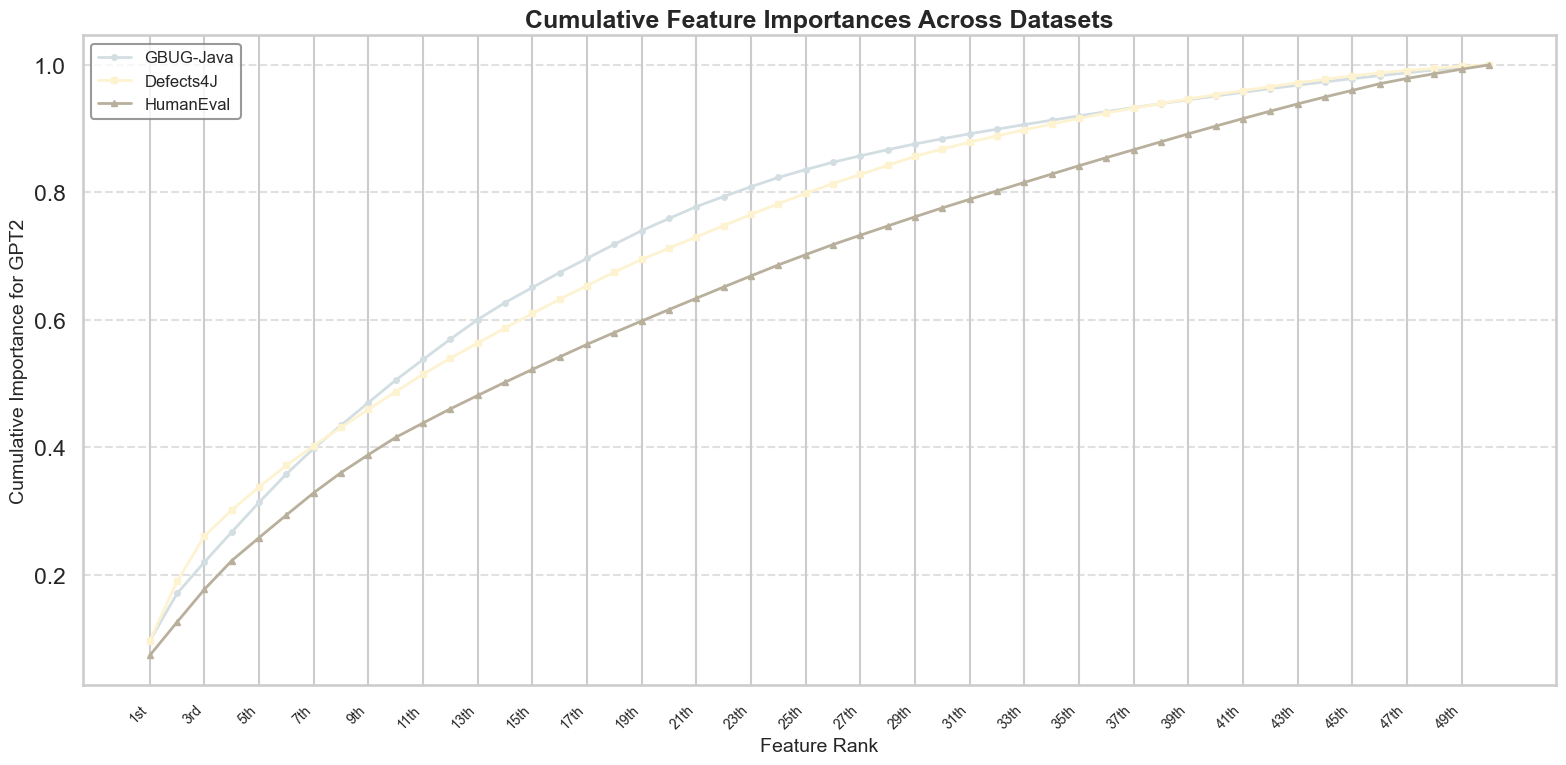

In [105]:
N_FEATURES_IMPORTANCE = 50

SAE_ACTIVATIONS_GBUG_GPT2_FEATURE_IMPORTANCE = SAE_ACTIVATIONS(
    layer=0,
    top_k=N_FEATURES_IMPORTANCE,
    original_dataset_path="../gpt2_gbug-java/",
)
SAE_ACTIVATIONS_DEFECTS4J_FEATURE_IMPORTANCE = SAE_ACTIVATIONS(
    layer=0,
    top_k=N_FEATURES_IMPORTANCE,
    original_dataset_path="../gpt2_defects4j/",
)
SAE_ACTIVATIONS_HUMANEVL_FEATURE_IMPORTANCE = SAE_ACTIVATIONS(
    layer=0,
    top_k=N_FEATURES_IMPORTANCE,
    original_dataset_path="../gpt2_humaneval/",
)

import numpy as np
import matplotlib.pyplot as plt

# Load models and settings
clf_gbug, top_k_gbug = load_sae_clf_settings(SAE_ACTIVATIONS_GBUG_GPT2_FEATURE_IMPORTANCE)
clf_defects4j, top_k_defects4j = load_sae_clf_settings(SAE_ACTIVATIONS_DEFECTS4J_FEATURE_IMPORTANCE)
clf_humaneval, top_k_humaneval = load_sae_clf_settings(SAE_ACTIVATIONS_HUMANEVL_FEATURE_IMPORTANCE)

# Get feature importances and compute cumulative sums
importances_gbug = np.cumsum(np.sort(clf_gbug.best_estimator_.feature_importances_)[::-1])
importances_defects4j = np.cumsum(np.sort(clf_defects4j.best_estimator_.feature_importances_)[::-1])
importances_humaneval = np.cumsum(np.sort(clf_humaneval.best_estimator_.feature_importances_)[::-1])

# Define x-axis labels
x_labels = [f"{i+1}st" if i == 0 else (f"{i+1}nd" if i == 1 else (f"{i+1}rd" if i == 2 else f"{i+1}th")) for i in range(N_FEATURES_IMPORTANCE)]

# Define custom color palette
color_gbug = "#d3dee3"      # Soft Blue-Grey
color_defects4j = "#fdf3d1"  # Light Yellow
color_humaneval = "#b8b09c"  # Neutral Grey
background_color = "#ffffff"  # White background for clarity

# Plotting
plt.figure(figsize=(16, 8))
plt.gca().set_facecolor(background_color)

plt.plot(importances_gbug, label="GBUG-Java", color=color_gbug, marker='o', markersize=4, linewidth=2)
plt.plot(importances_defects4j, label="Defects4J", color=color_defects4j, marker='s', markersize=4, linewidth=2)
plt.plot(importances_humaneval, label="HumanEval", color=color_humaneval, marker='^', markersize=4, linewidth=2)

# X-axis settings
step = max(1, len(x_labels) // 20)
plt.xticks(range(0, len(x_labels), step), x_labels[::step], rotation=45, ha='right', fontsize=10)

# Labels, grid, legend
plt.xlabel("Feature Rank", fontsize=14)
plt.ylabel("Cumulative Importance for GPT2", fontsize=14)
plt.title("Cumulative Feature Importances Across Datasets", fontsize=18, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=12, frameon=True, facecolor=background_color, edgecolor='grey')

plt.tight_layout()
plt.show()

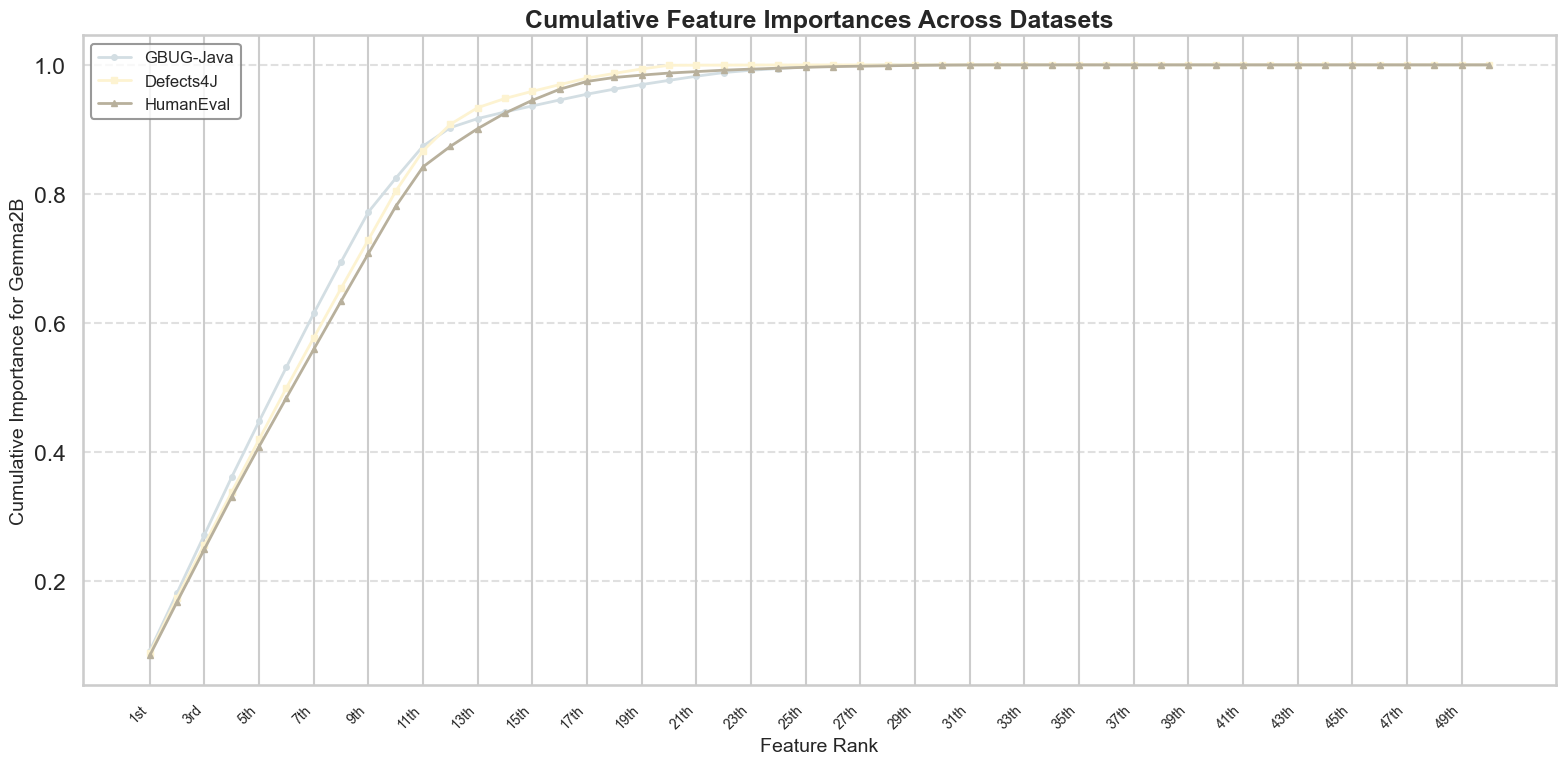

In [103]:

SAE_ACTIVATIONS_GBUG_GEMMA2_FEATURE_IMPORTANCE = SAE_ACTIVATIONS(
    layer=1,
    top_k=N_FEATURES_IMPORTANCE,
    original_dataset_path="../gemma2_gbug-java/",
    base_gbug_path="../gemma2_gbug-java/",
    base_defects_path="../gemma2_defects4j/",
    base_humaneval_path="../gemma2_humaneval/"
)
SAE_ACTIVATIONS_DEFECTS4J_GEMMA2_FEATURE_IMPORTANCE = SAE_ACTIVATIONS(
    layer=1,
    top_k=N_FEATURES_IMPORTANCE,
    original_dataset_path="../gemma2_defects4j/",
    base_gbug_path="../gemma2_gbug-java/",
    base_defects_path="../gemma2_defects4j/",
    base_humaneval_path="../gemma2_humaneval/"
)
SAE_ACTIVATIONS_HUMANEVL_GEMMA2_FEATURE_IMPORTANCE = SAE_ACTIVATIONS(
    layer=1,
    top_k=N_FEATURES_IMPORTANCE,
    original_dataset_path="../gemma2_humaneval/",
    base_gbug_path="../gemma2_gbug-java/",
    base_defects_path="../gemma2_defects4j/",
    base_humaneval_path="../gemma2_humaneval/"
)


import numpy as np
import matplotlib.pyplot as plt

# Load models and settings
clf_gbug, top_k_gbug = load_sae_clf_settings(SAE_ACTIVATIONS_GBUG_GEMMA2_FEATURE_IMPORTANCE)
clf_defects4j, top_k_defects4j = load_sae_clf_settings(SAE_ACTIVATIONS_DEFECTS4J_GEMMA2_FEATURE_IMPORTANCE)
clf_humaneval, top_k_humaneval = load_sae_clf_settings(SAE_ACTIVATIONS_HUMANEVL_GEMMA2_FEATURE_IMPORTANCE)

# Get feature importances and compute cumulative sums
importances_gbug = np.cumsum(np.sort(clf_gbug.best_estimator_.feature_importances_)[::-1])
importances_defects4j = np.cumsum(np.sort(clf_defects4j.best_estimator_.feature_importances_)[::-1])
importances_humaneval = np.cumsum(np.sort(clf_humaneval.best_estimator_.feature_importances_)[::-1])

# Define x-axis labels
x_labels = [f"{i+1}st" if i == 0 else (f"{i+1}nd" if i == 1 else (f"{i+1}rd" if i == 2 else f"{i+1}th")) for i in range(N_FEATURES_IMPORTANCE)]

# Define custom color palette
color_gbug = "#d3dee3"      # Soft Blue-Grey
color_defects4j = "#fdf3d1"  # Light Yellow
color_humaneval = "#b8b09c"  # Neutral Grey
background_color = "#ffffff"  # White background for clarity

# Plotting
plt.figure(figsize=(16, 8))
plt.gca().set_facecolor(background_color)

plt.plot(importances_gbug, label="GBUG-Java", color=color_gbug, marker='o', markersize=4, linewidth=2)
plt.plot(importances_defects4j, label="Defects4J", color=color_defects4j, marker='s', markersize=4, linewidth=2)
plt.plot(importances_humaneval, label="HumanEval", color=color_humaneval, marker='^', markersize=4, linewidth=2)

# X-axis settings
step = max(1, len(x_labels) // 20)
plt.xticks(range(0, len(x_labels), step), x_labels[::step], rotation=45, ha='right', fontsize=10)

# Labels, grid, legend
plt.xlabel("Feature Rank", fontsize=14)
plt.ylabel("Cumulative Importance for Gemma2B", fontsize=14)
plt.title("Cumulative Feature Importances Across Datasets", fontsize=18, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=12, frameon=True, facecolor=background_color, edgecolor='grey')

plt.tight_layout()
plt.show()


# Load prestored data

In [62]:
from typing import Dict
def read_saved_results(
    path="../artifacts/transferability_results.jsonl",
    transferability: bool = True,
) -> Dict[str, TransferabilityPerformance]:
    """
    Read the saved results from the jsonl file.
    """
    our_dict = {}
    with open(path, "r") as f:
        for line in f:
            data = json.loads(line)
            for key, value in data.items():
                if transferability:
                    if key.startswith("trans"):
                        our_dict[key] = TransferabilityPerformance(**value)
                else:
                    if key.startswith("trans"):
                        continue
                    our_dict[key] = Results(**value)
    return our_dict
    

In [112]:
transferability_results = read_saved_results()
print(transferability_results.keys())

transf_rf_gbug_gpt2 = transferability_results["transf_rf_gbug_gpt2"]
transf_rf_defects4j_gpt2 = transferability_results["transf_rf_defects4j_gpt2"]
transf_rf_humaneval_gpt2 = transferability_results["transf_rf_humaneval_gpt2"]
transf_rf_gbug_gemma2 = transferability_results["transf_rf_gbug_gemma2"]
transf_rf_defects4j_gemma2 = transferability_results["transf_rf_defects4j_gemma2"]
transf_rf_humaneval_gemma2 = transferability_results["transf_rf_humaneval_gemma2"]
transf_rf_gbug = transferability_results["transf_rf_gbug"]
transf_knn_gbug = transferability_results["transf_knn_gbug"]
transf_rf_defects = transferability_results["transf_rf_defects"]
transf_knn_defects = transferability_results["transf_knn_defects"]
transf_rf_humaneval = transferability_results["transf_rf_humaneval"]
transf_knn_humaneval = transferability_results["transf_knn_humaneval"]
transf_modern_bert_large_gbug = transferability_results["transf_modern_bert_large_gbug"]
transf_modern_bert_large_defects = transferability_results["transf_modern_bert_large_defects"]
transf_modern_bert_large_humaneval = transferability_results["transf_modern_bert_large_humaneval"]
transf_modern_bert_base_gbug = transferability_results["transf_modern_bert_base_gbug"]
transf_modern_bert_base_defects = transferability_results["transf_modern_bert_base_defects"]
transf_modern_bert_base_humaneval = transferability_results["transf_modern_bert_base_humaneval"]
transf_graph_code_bert_humaneval = transferability_results["transf_graph_code_bert_humaneval"]
transf_graph_code_bert_gbug = transferability_results["transf_graph_code_bert_gbug"]
transf_graph_code_bert_defects = transferability_results["transf_graph_code_bert_defects"]


dict_keys(['transf_rf_gbug_gpt2', 'transf_rf_defects4j_gpt2', 'transf_rf_humaneval_gpt2', 'transf_rf_gbug_gemma2', 'transf_rf_defects4j_gemma2', 'transf_rf_humaneval_gemma2', 'transf_knn_gbug', 'transf_knn_defects', 'transf_rf_defects', 'transf_knn_humaneval', 'transf_rf_humaneval', 'transf_modern_bert_large_gbug', 'transf_modern_bert_large_defects', 'transf_modern_bert_large_humaneval', 'transf_modern_bert_base_gbug', 'transf_modern_bert_base_defects', 'transf_modern_bert_base_humaneval', 'transf_graph_code_bert_gbug', 'transf_graph_code_bert_defects', 'transf_graph_code_bert_humaneval', 'transf_rf_gbug'])


In [64]:
results = read_saved_results(transferability=False)
print(results.keys())

results_gbug_knn = results["results_gbug_knn"]
results_gbug_rf = results["results_gbug_rf"]
results_defects_knn = results["results_defects_knn"]
results_defects_rf = results["results_defects_rf"]
results_humaneval_knn = results["results_humaneval_knn"]
results_humaneval_rf = results["results_humaneval_rf"]
results_modern_bert_base_gbug = results["results_modern_bert_base_gbug"]
results_modern_bert_base_defects = results["results_modern_bert_base_defects"]
results_modern_bert_base_humaneval = results["results_modern_bert_base_humaneval"]
results_modern_bert_large_gbug = results["results_modern_bert_large_gbug"]
results_modern_bert_large_defects = results["results_modern_bert_large_defects"]
results_modern_bert_large_humaneval = results["results_modern_bert_large_humaneval"]
results_graph_code_bert_gbug = results["results_graph_code_bert_gbug"]
results_graph_code_bert_defects = results["results_graph_code_bert_defects"]
results_graph_code_bert_humaneval = results["results_graph_code_bert_humaneval"]
sae_rf_gbug_gpt2 = results["sae_rf_gbug_gpt2"]
sae_rf_defects4j_gpt2 = results["sae_rf_defects4j"]
sae_rf_humaneval_gpt2 = results["sae_rf_humaneval"]
sae_rf_gbug_gemma2 = results["sae_rf_gbug_gemma2"]
sae_rf_defects4j_gemma2 = results["sae_rf_defects4j_gemma2"]
sae_rf_humaneval_gemma2 = results["sae_rf_humaneval_gemma2"]



dict_keys(['sae_rf_gbug_gpt2', 'sae_rf_gbug_gpt2_on_defects4j', 'sae_rf_gbug_gpt2_on_humaneval', 'sae_rf_defects4j', 'sae_rf_defects4j_on_gbug', 'sae_rf_defects4j_on_humaneval', 'sae_rf_humaneval', 'sae_rf_humaneval_on_gbug', 'sae_rf_humaneval_on_defects4j', 'sae_rf_gbug_gemma2', 'sae_rf_gbug_gemma2_on_defects4j', 'sae_rf_gbug_gemma2_on_humaneval', 'sae_rf_defects4j_gemma2', 'sae_rf_defects4j_gemma2_on_gbug', 'sae_rf_defects4j_gemma2_on_humaneval', 'sae_rf_humaneval_gemma2', 'sae_rf_humaneval_gemma2_on_gbug', 'sae_rf_humaneval_gemma2_on_defects4j', 'results_gbug_knn', 'results_gbug_knn_defects', 'results_gbug_knn_human', 'results_gbug_rf', 'results_gbug_rf_defects', 'results_gbug_rf_human', 'results_defects_knn', 'results_defects_knn_gbug', 'results_defects_knn_human', 'results_defects_rf', 'results_defects_rf_gbug', 'results_defects_rf_human', 'results_humaneval_knn', 'results_humaneval_knn_gbug', 'results_humaneval_knn_defects', 'results_humaneval_rf', 'results_humaneval_rf_gbug', 'r

# Graphs

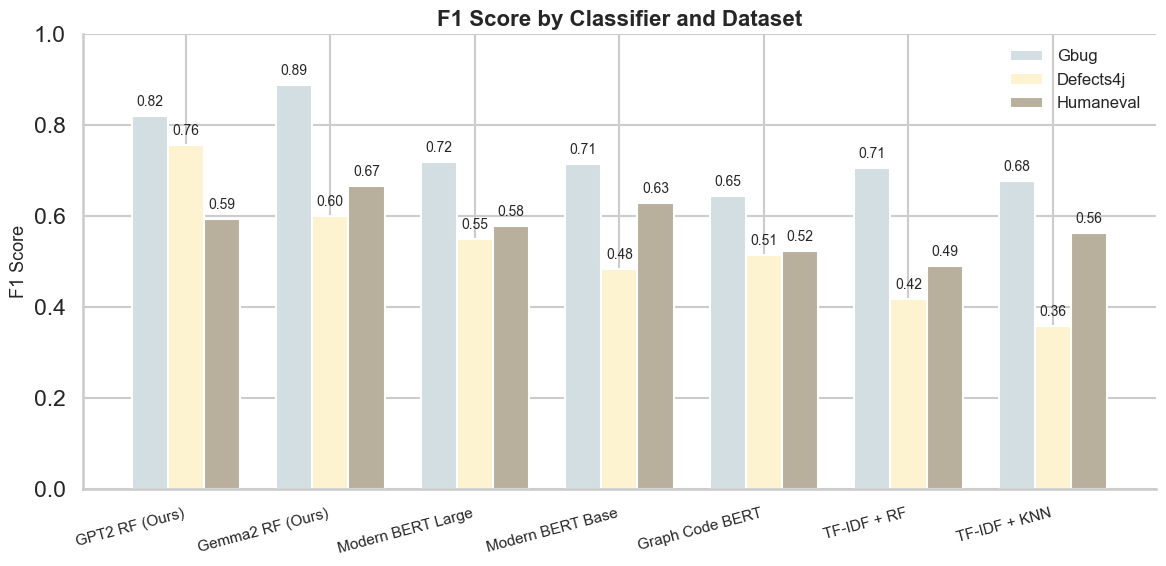

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Custom color palette inspired by the diagram
colors = {
    "gbug": "#d3dee3",         # Soft Blue-Grey
    "defects": "#fdf3d1",      # Light Yellow
    "humaneval": "#b8b09c"     # Neutral Grey
}

sns.set(style="whitegrid", context="talk")

methods = ['GPT2 RF (Ours)', 'Gemma2 RF (Ours)', 'Modern BERT Large', 'Modern BERT Base', 'Graph Code BERT',
           'TF-IDF + RF', 'TF-IDF + KNN']

# Replace these with your actual F1 values
results_gbug = [
    sae_rf_gbug_gpt2.f1,
    sae_rf_gbug_gemma2.f1,
    results_modern_bert_large_gbug.f1,
    results_modern_bert_base_gbug.f1,
    results_graph_code_bert_gbug.f1,
    results_gbug_rf.f1,
    results_gbug_knn.f1,
]
results_defects = [
    sae_rf_defects4j_gpt2.f1,
    sae_rf_defects4j_gemma2.f1,
    results_modern_bert_large_defects.f1,
    results_modern_bert_base_defects.f1,
    results_graph_code_bert_defects.f1,
    results_defects_rf.f1,
    results_defects_knn.f1,
]
results_humaneval = [
    sae_rf_humaneval_gpt2.f1,
    sae_rf_humaneval_gemma2.f1,
    results_modern_bert_large_humaneval.f1,
    results_modern_bert_base_humaneval.f1,
    results_graph_code_bert_humaneval.f1,
    results_humaneval_rf.f1,
    results_humaneval_knn.f1,
]

x = np.arange(len(methods))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, results_gbug, width, label='Gbug', color=colors["gbug"])
rects2 = ax.bar(x, results_defects, width, label='Defects4j', color=colors["defects"])
rects3 = ax.bar(x + width, results_humaneval, width, label='Humaneval', color=colors["humaneval"])

# Aesthetics
ax.set_ylabel('F1 Score', fontsize=13)
ax.set_title('F1 Score by Classifier and Dataset', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right', fontsize=11)
ax.set_ylim(0, 1)
ax.legend(fontsize=12, loc='upper right', frameon=False)
sns.despine()

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


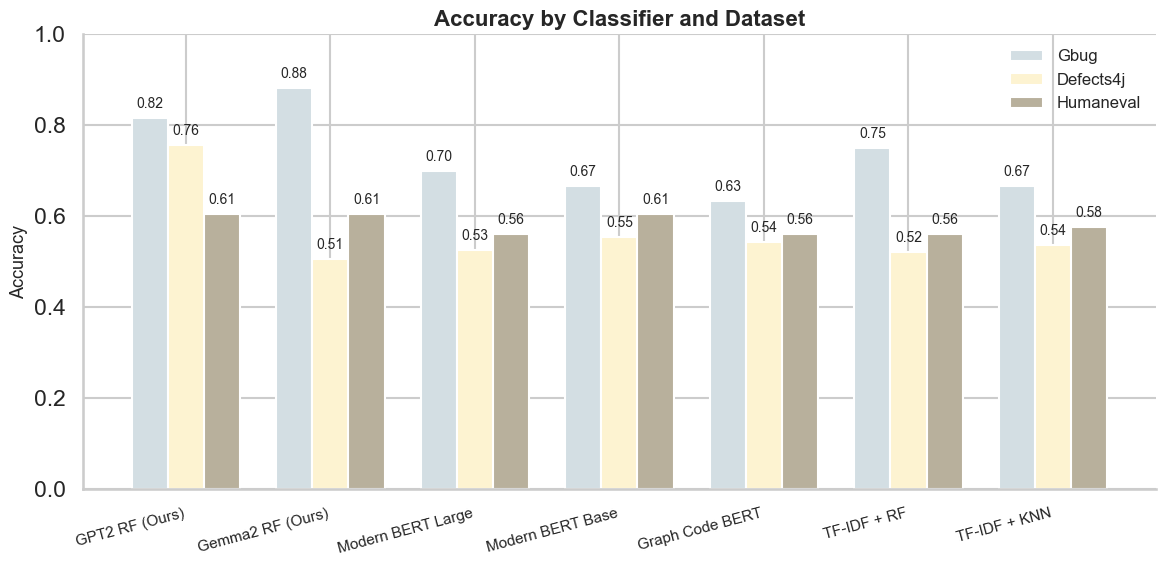

In [116]:
# Now for accuracy
results_gbug = [
    sae_rf_gbug_gpt2.accuracy,
    sae_rf_gbug_gemma2.accuracy,
    results_modern_bert_large_gbug.accuracy,
    results_modern_bert_base_gbug.accuracy,
    results_graph_code_bert_gbug.accuracy,
    results_gbug_rf.accuracy,
    results_gbug_knn.accuracy,
]
results_defects = [
    sae_rf_defects4j_gpt2.accuracy,
    sae_rf_defects4j_gemma2.accuracy,
    results_modern_bert_large_defects.accuracy,
    results_modern_bert_base_defects.accuracy,
    results_graph_code_bert_defects.accuracy,
    results_defects_rf.accuracy,
    results_defects_knn.accuracy,
]
results_humaneval = [
    sae_rf_humaneval_gpt2.accuracy,
    sae_rf_humaneval_gemma2.accuracy,
    results_modern_bert_large_humaneval.accuracy,
    results_modern_bert_base_humaneval.accuracy,
    results_graph_code_bert_humaneval.accuracy,
    results_humaneval_rf.accuracy,
    results_humaneval_knn.accuracy,
]

x = np.arange(len(methods))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, results_gbug, width, label='Gbug', color=colors["gbug"])
rects2 = ax.bar(x, results_defects, width, label='Defects4j', color=colors["defects"])
rects3 = ax.bar(x + width, results_humaneval, width, label='Humaneval', color=colors["humaneval"])

# Aesthetics
ax.set_ylabel('Accuracy', fontsize=13)
ax.set_title('Accuracy by Classifier and Dataset', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right', fontsize=11)
ax.set_ylim(0, 1)
ax.legend(fontsize=12, loc='upper right', frameon=False)
sns.despine()

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()



In [125]:

# Transfer direction labels
labels = [
    "Gbug → Defects4J", "Gbug → HumanEval",
    "Defects4J → Gbug", "Defects4J → HumanEval",
    "HumanEval → Gbug", "HumanEval → Defects4J",
]

# Values for each model
all_values = [
    [
        transf_rf_gbug_gpt2.on_defects, transf_rf_gbug_gpt2.on_humaneval,
        transf_rf_defects4j_gpt2.on_gbug, transf_rf_defects4j_gpt2.on_humaneval,
        transf_rf_humaneval_gpt2.on_gbug, transf_rf_humaneval_gpt2.on_defects,
    ],
    [
        transf_rf_gbug_gemma2.on_defects, transf_rf_gbug_gemma2.on_humaneval,
        transf_rf_defects4j_gemma2.on_gbug, transf_rf_defects4j_gemma2.on_humaneval,
        transf_rf_humaneval_gemma2.on_gbug, transf_rf_humaneval_gemma2.on_defects,
    ],
    [
        transf_modern_bert_large_gbug_on_defects, transf_modern_bert_large_gbug_on_human,
        transf_modern_bert_large_defects_on_gbug, transf_modern_bert_large_defects_on_human,
        transf_modern_bert_large_humaneval_on_gbug, transf_modern_bert_large_humaneval_on_defects,
    ],
    [
        transf_modern_bert_base_gbug.on_defects, transf_modern_bert_base_gbug.on_humaneval,
        transf_modern_bert_base_defects.on_gbug, transf_modern_bert_base_defects.on_humaneval,
        transf_modern_bert_base_humaneval.on_gbug, transf_modern_bert_base_humaneval.on_defects,
    ],
    [
        transf_graph_code_bert_gbug.on_defects, transf_graph_code_bert_gbug.on_humaneval,
        transf_graph_code_bert_defects.on_gbug, transf_graph_code_bert_defects.on_humaneval,
        transf_graph_code_bert_humaneval.on_gbug, transf_graph_code_bert_humaneval.on_defects,
    ],
    [
        transf_rf_gbug.on_defects, transf_rf_gbug.on_humaneval,
        transf_rf_defects.on_gbug, transf_rf_defects.on_humaneval,
        transf_rf_humaneval.on_gbug, transf_rf_humaneval.on_defects,
    ],
    [
        transf_knn_gbug.on_defects, transf_knn_gbug.on_humaneval,
        transf_knn_defects.on_gbug, transf_knn_defects.on_humaneval,
        transf_knn_humaneval.on_gbug, transf_knn_humaneval.on_defects,
    ],
]

methods = [
           'GPT2 RF (Ours)', 
           "Gemma2 RF (Ours)",
           'Modern BERT Large',
           'Modern BERT Base',
           'Graph Code BERT',
           #'TF-IDF + RF', 
           #'TF-IDF + KNN'
           ]
colors = [
    "#d3dee3",  # Soft Blue-Grey
    "#fdf3d1",  # Light Yellow
    "#b8b09c",  # Neutral Grey
    "#909291",  # Grey
    "#746c5c",
    "#e5d8bc",
    "#f2e6d4",  # Light Beige
    "#d9d9d9",  # Light Grey
]


# Hatching patterns for accessibility
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', '.']



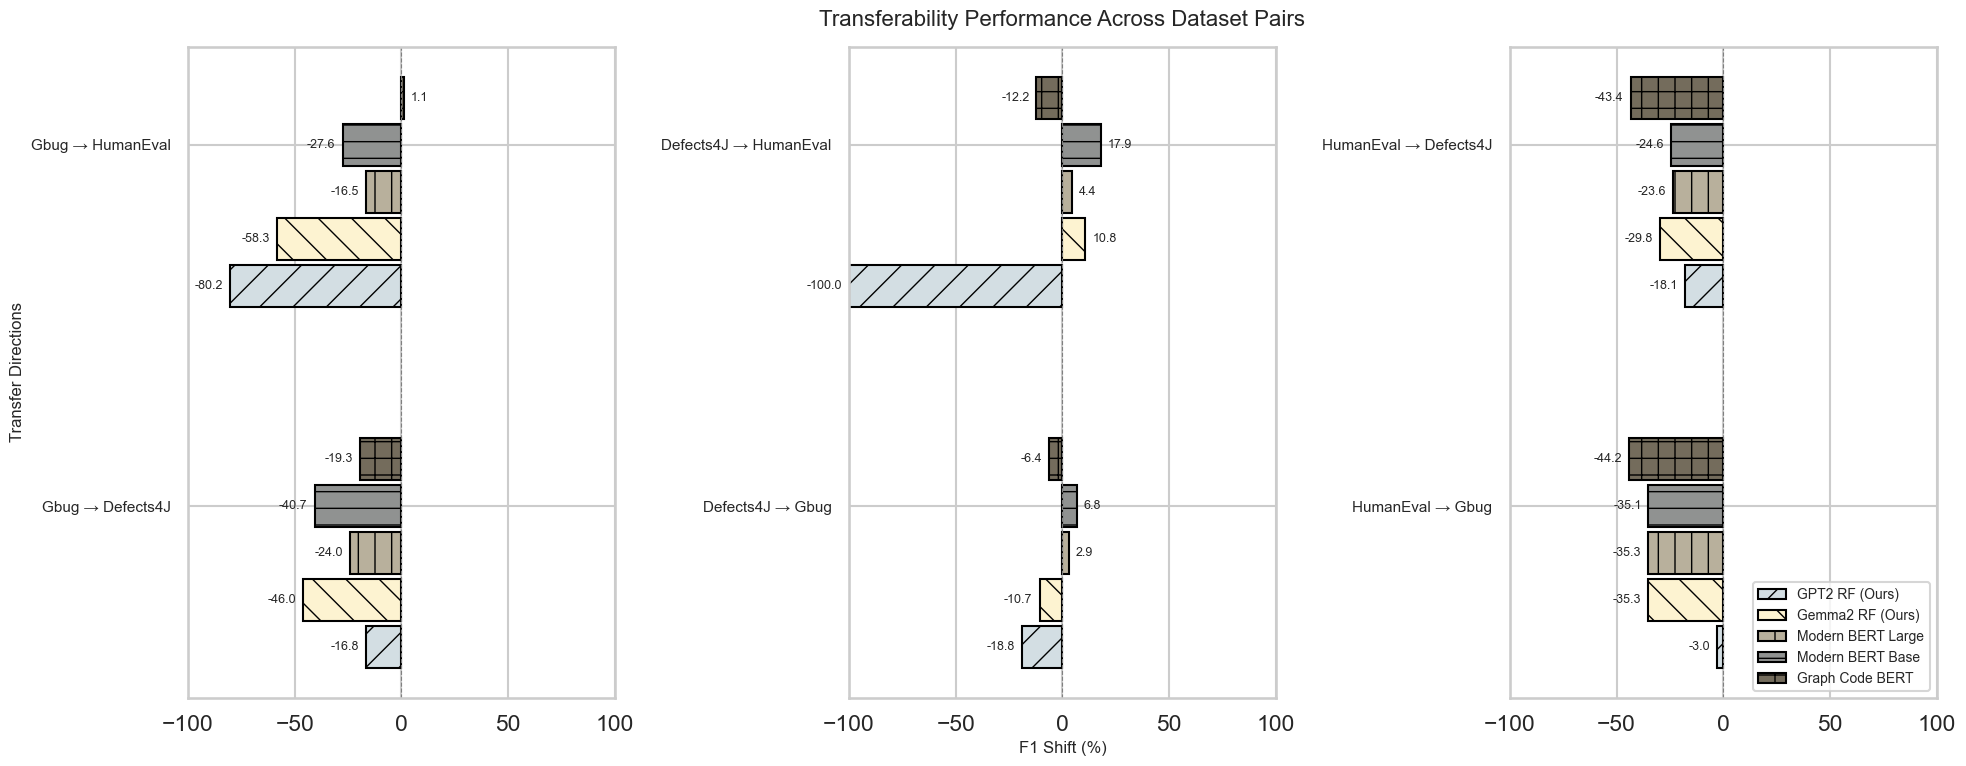

In [126]:
# Subsets for each direction group
group_indices = [
    [0, 1],  # Gbug →
    [2, 3],  # Defects4J →
    [4, 5],  # HumanEval →
]

fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharex=True)

width = 0.13

for ax_idx, ax in enumerate(axs):
    x = np.arange(2)
    for i, (method_vals, method_name, color, hatch) in enumerate(zip(all_values, methods, colors, hatches)):
        offset = (i - len(all_values)/2) * width + width/2
        for j, idx in enumerate(group_indices[ax_idx]):
            val = method_vals[idx]
            if not np.isnan(val):
                ax.barh(x[j] + offset, val, height=width * 0.9,
                        label=method_name if j == 0 else "",
                        color=color, hatch=hatch, edgecolor='black')
                ax.annotate(f'{val:.1f}',
                            xy=(val, x[j] + offset),
                            xytext=(5 if val >= 0 else -5, 0),
                            textcoords='offset points',
                            ha='left' if val >= 0 else 'right',
                            va='center',
                            fontsize=9)
    
    ax.set_yticks(x)
    ax.set_yticklabels([labels[i] for i in group_indices[ax_idx]], fontsize=11)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_xlim(-100, 100)
    if ax_idx == 0:
        ax.set_ylabel("Transfer Directions", fontsize=12)
    if ax_idx == 1:
        ax.set_xlabel("F1 Shift (%)", fontsize=12)

    # Set limits for the x-axis
    ax.set_xlim(-100, 100)

axs[1].set_title("Transferability Performance Across Dataset Pairs", fontsize=16, pad=15)

# Legend on last subplot
handles, labels_uniq = axs[-1].get_legend_handles_labels()
unique = dict(zip(labels_uniq, handles))
axs[-1].legend(unique.values(), unique.keys(), loc='lower right', fontsize=10, frameon=True)

plt.tight_layout()
plt.show()